# Sep 3, 2023: Emoprox2 dataset: ICA

In [1]:
import csv
import os
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
from sklearn.decomposition import FastICA, PCA
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy


# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
class ARGS(): pass
args = ARGS()

args.SEED = 100
np.random.seed(args.SEED)

In [3]:
emoprox_dir = pjoin(os.environ['HOME'], 'emoprox_inventory_govinda/emoprox_extract_timeseries')

# ROI atlas/parcellation
atlas_df = pd.read_csv(f"{emoprox_dir}/masks/README_MAX_ROIs_final_gm_85.txt", delimiter='\t')
# display(atlas_df)

roi = 'dorsal Insula'
roi_idx = np.where(atlas_df['Hemi'].str.contains('R') * atlas_df['ROI'].str.contains(roi))[0]
display(atlas_df.iloc[roi_idx])

# data
data_df = pd.read_pickle(f"{emoprox_dir}/dataframes/MAX_ROIs.pkl")

data_df['proximity'] = data_df['proximity'].apply(lambda prox: sp.stats.zscore(prox))

,Hemi,ROI,Index,Voxels,File_Name
49,R,ant. dorsal Insula,50,235,Hammers-gm-0.5-2mm-AntDorsal-INS-r.nii.gz


In [4]:
# mean time series across subjects
rids = []
blocks = []
times = []
tss = []
proxs = []
censors = []
for rid, block in list(product(data_df['rid'].unique(), data_df['block'].unique())):
    # print(rid, block)
    rids.append(rid)
    blocks.append(block)
    df_ = data_df[data_df['rid'] == rid][data_df['block'] == block]
    lmin = np.min(df_['timeseries'].apply(lambda x: x.shape[0]).values)
    times.append(df_['time'].iloc[0][:lmin])
    tss.append(df_['timeseries'].apply(lambda x: x[:lmin, ...]).mean())
    proxs.append(df_['proximity'].apply(lambda x: x[:lmin, ...]).mean())
    censors.append(df_['censor'].values[0][:lmin, 0])

df = pd.DataFrame(
    data={
        'rid': rids,
        'block': blocks,
        'time': times,
        'timeseries': tss,
        'proximity': proxs,
        'censor':censors,
        },
)
df

,rid,block,time,timeseries,proximity,censor
0,0,1,"[0.0, 1.25, 2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 1...","[[-0.02390497788475301, -0.04270538325639377, ...","[-1.2079791745344644, -0.9047940812561361, -0....","[True, True, True, True, True, True, True, Tru..."
1,0,2,"[212.5, 213.75, 215.0, 216.25, 217.5, 218.75, ...","[[-0.16295314653691623, -0.01666933747741346, ...","[0.017511788254418383, 0.2679718311407305, 0.6...","[True, True, True, True, True, True, True, Tru..."
2,1,1,"[0.0, 1.25, 2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 1...","[[-0.198032265266743, -0.13559650586994343, -0...","[0.13131557794480705, -0.08549816680325, -0.30...","[True, True, True, True, True, True, True, Tru..."
3,1,2,"[211.25, 212.5, 213.75, 215.0, 216.25, 217.5, ...","[[0.15476719317870366, 0.16892929443746676, 0....","[-0.3047569397545775, -0.08603546353546888, 0....","[True, True, True, True, True, True, True, Tru..."
4,2,1,"[0.0, 1.25, 2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 1...","[[-0.1134854874655991, -0.13134632084245404, -...","[-0.04327633268643199, -0.3035262893146636, -0...","[True, True, True, True, True, True, True, Tru..."
5,2,2,"[213.75, 215.0, 216.25, 217.5, 218.75, 220.0, ...","[[-0.25074962623687325, -0.02089252445433281, ...","[-0.4111067901733918, -0.5915982171252103, -0....","[True, True, True, True, True, True, True, Tru..."
6,3,1,"[0.0, 1.25, 2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 1...","[[-0.06581703739227845, -0.15415326977058338, ...","[-0.513334016610507, -0.282239826108365, -0.05...","[True, True, True, True, True, True, True, Tru..."
7,3,2,"[213.75, 215.0, 216.25, 217.5, 218.75, 220.0, ...","[[-0.3144177276600097, 0.06739999981492178, -0...","[-0.8029868682572703, -0.5041406737913097, -0....","[True, True, True, True, True, True, True, Tru..."
8,4,1,"[0.0, 1.25, 2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 1...","[[-0.2435785864687706, -0.28628994882598463, -...","[0.240098562306032, -0.021445949927976136, -0....","[True, True, True, True, True, True, True, Tru..."
9,4,2,"[213.75, 215.0, 216.25, 217.5, 218.75, 220.0, ...","[[-0.4302520248277172, -0.18604681879257243, 0...","[0.13384122043478605, -0.05342583016181571, -0...","[True, True, True, True, True, True, True, Tru..."


## spatial ica

In [5]:
args.n_comps = 10
ica = FastICA(
    n_components=args.n_comps, 
    whiten='unit-variance',
    max_iter=1000,
)
X = df.iloc[0]['timeseries']
t = df.iloc[0]['time']
prox = df.iloc[0]['proximity']
censor = df.iloc[0]['censor']
S = ica.fit_transform(X)
A = ica.mixing_
print(S.shape, A.shape, np.linalg.matrix_rank(A))
X_ = ica.inverse_transform(S)
# np.allclose(X, X_)

(145, 10) (85, 10) 10


In [6]:
R = []; P = []
for i in range(S.shape[1]):
   res = sp.stats.pearsonr(S[:, i], prox)
   R.append(res.statistic)
   P.append(res.pvalue)
R = np.array(R)
P = np.array(P)

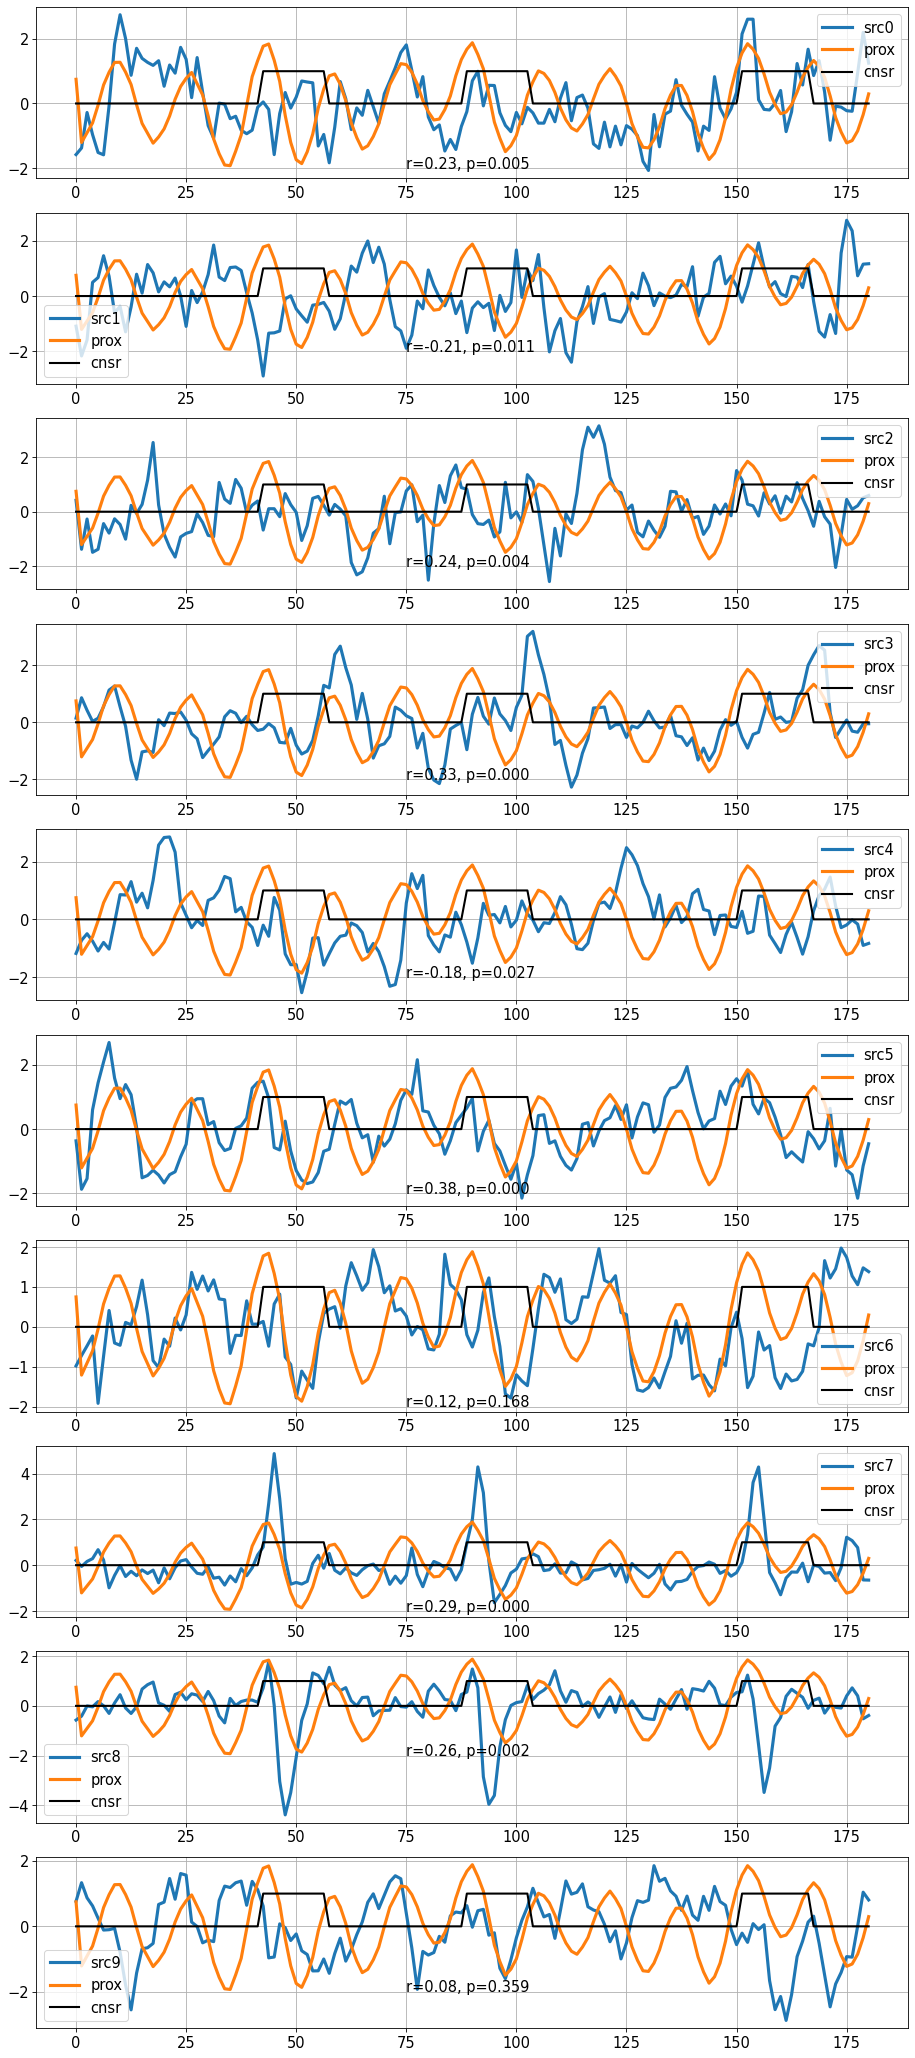

In [7]:
fig, axs = plt.subplots(
    nrows=args.n_comps, ncols=1,
    figsize=(15, 3.5*args.n_comps),
    dpi=75
)
# prox_ = deepcopy(prox)
prox_ = np.roll(prox, 1)
for idx in range(args.n_comps):
    ax = axs[idx]
    ax.plot(t, S[:, idx], linewidth=3, label=f'src{idx}')
    ax.plot(t, prox_, linewidth=3, label='prox')
    ax.plot(t, 1-censor, linewidth=2, c='k', label='cnsr')
    ax.text(75, -2.0, f"r={R[idx]:.2f}, p={P[idx]:.3f}")
    ax.legend()
    ax.grid(True)

source 7 follows shock onset. 
source 5 follows proximity stimulus.

<AxesSubplot: >

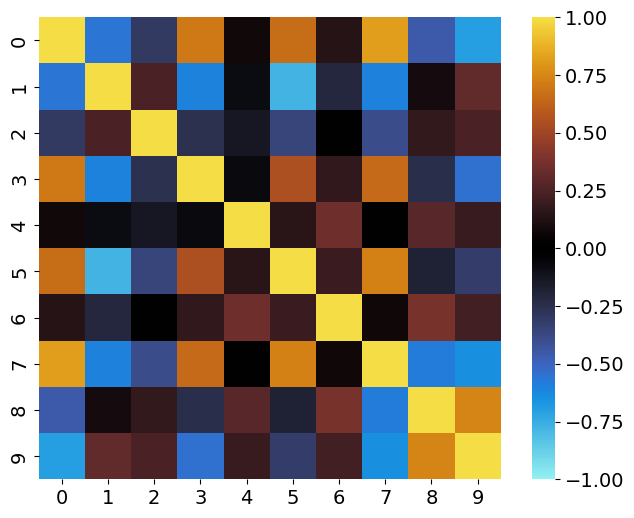

In [8]:
R = np.corrcoef(A.T)
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
ax = axs
sns.heatmap(R, vmin=-1, vmax=1, square=True, cmap=cmr.iceburn)

## pca

In [9]:
pca = PCA(n_components=args.n_comps)
Y = pca.fit_transform(X)
U = pca.components_
print(U.shape, Y.shape)
X_ = pca.inverse_transform(Y)
X_.shape

(10, 85) (145, 10)


(145, 85)

array([0.61997789, 0.73954399, 0.80111766, 0.82523575, 0.84392391,
       0.85797174, 0.86852079, 0.87686971, 0.88483034, 0.89219864])

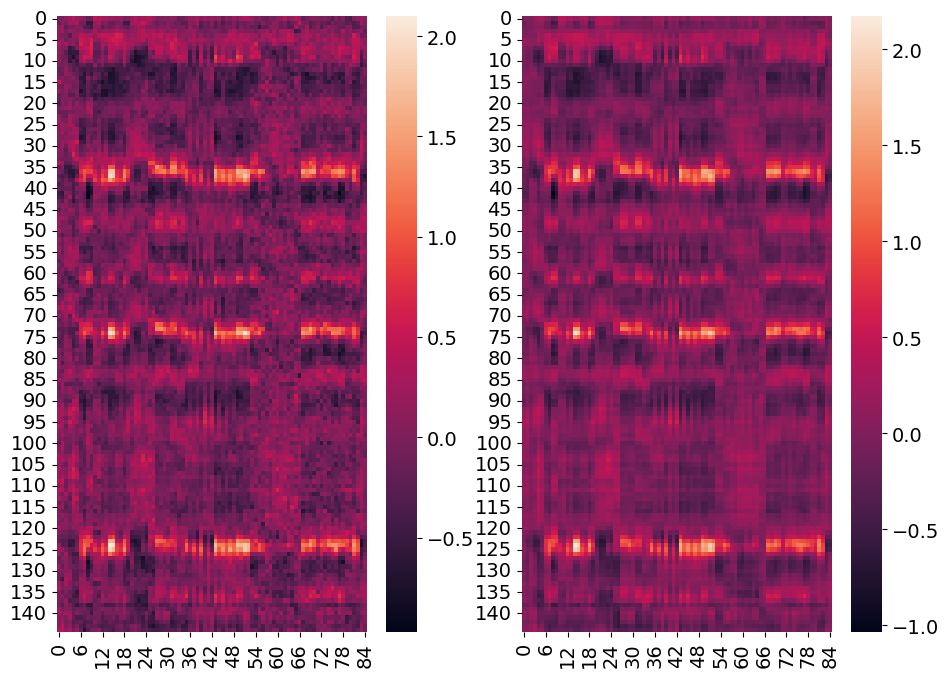

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(11, 8))
ax = axs[0]
sns.heatmap(X, ax=ax)
ax = axs[1]
sns.heatmap(X_, ax=ax)

np.cumsum(pca.explained_variance_ratio_)

<AxesSubplot: >

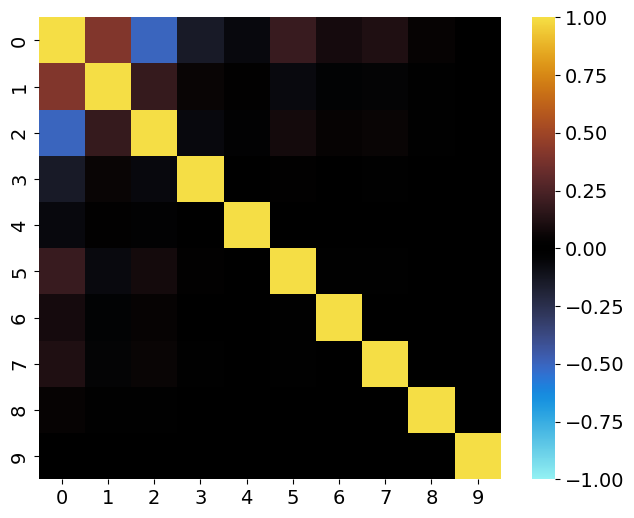

In [11]:
R = np.corrcoef(U)
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
ax = axs
sns.heatmap(R, vmin=-1, vmax=1, square=True, cmap=cmr.iceburn)

## temporal ica

In [12]:
args.n_comps = 10
ica = FastICA(
    n_components=args.n_comps, 
    whiten='unit-variance',
    max_iter=1000,
)
X = df.iloc[0]['timeseries']
t = df.iloc[0]['time']
prox = df.iloc[0]['proximity']
censor = df.iloc[0]['censor']
S = ica.fit_transform(X.T)
A = ica.mixing_
print(S.shape, A.shape, np.linalg.matrix_rank(A))
X_ = ica.inverse_transform(S)
# np.allclose(X, X_)
A_ = sp.stats.zscore(A)

(85, 10) (145, 10) 10


In [13]:
R = []; P = []
for i in range(S.shape[1]):
   res = sp.stats.pearsonr(A_[:, i], prox)
   R.append(res.statistic)
   P.append(res.pvalue)
R = np.array(R)
P = np.array(P)

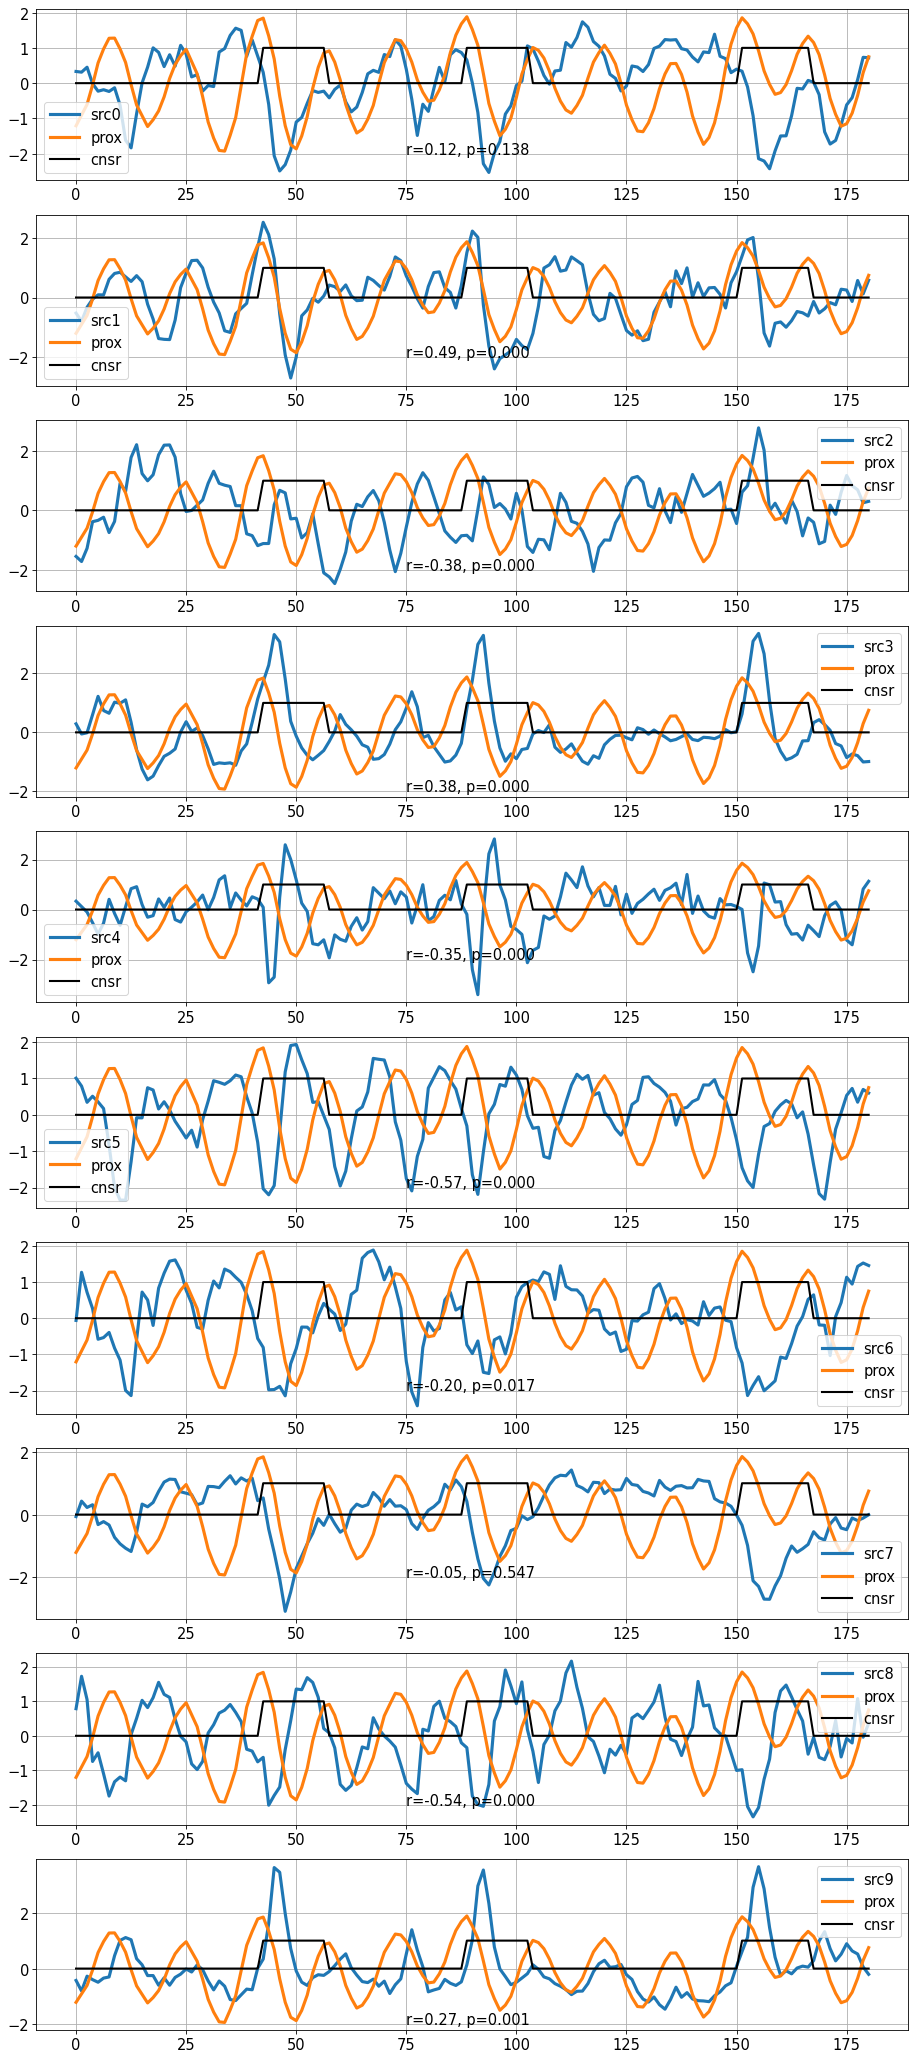

In [14]:
fig, axs = plt.subplots(
    nrows=args.n_comps, ncols=1,
    figsize=(15, 3.5*args.n_comps),
    dpi=75
)
prox_ = deepcopy(prox)
# prox_ = np.roll(prox, 1)
for idx in range(args.n_comps):
    ax = axs[idx]
    ax.plot(t, A_[:, idx], linewidth=3, label=f'src{idx}')
    ax.plot(t, prox_, linewidth=3, label='prox')
    ax.plot(t, 1-censor, linewidth=2, c='k', label='cnsr')
    ax.text(75, -2.0, f"r={R[idx]:.2f}, p={P[idx]:.3f}")
    ax.legend()
    ax.grid(True)